In [15]:
# ! pip install tqdm tensorflow_hub xlrd nltk matplotlib tensorflow

In [51]:
%matplotlib inline

In [48]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from scipy import spatial
from tqdm import tqdm
import nltk
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
from nltk.tokenize import sent_tokenize

In [14]:
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [16]:
def split_to_sentences(data):
    sentences = [s for d in data for s in d.split('\n')]
    sentences = [s.strip() for s in sentences]
    sentences = [re.sub('&#39;', '\'', s) for s in sentences]
    sentences = [re.sub('…', '...', s) for s in sentences]
    sentences = [s for line in sentences for s in sent_tokenize(line) if s]
    new_sentences = []
    for s in sentences:
        if len(s)>=512:
            new_sentences += s.split(',')
        else:
            new_sentences.append(s)
    return new_sentences

In [17]:
data = []
dirname = 'data/thoughts/Thoughts_en/'
for fname in tqdm(os.listdir(dirname)):
    if not fname.endswith('.docx'):
        continue
    with open(f"{dirname}/{fname}") as f:
        data +=  [f.read()]

100%|██████████| 438/438 [00:02<00:00, 211.65it/s]


In [69]:
data = []
dirname = 'data/thoughts/ids/'
for fname in tqdm(os.listdir(dirname)):
    if not fname.endswith('.txt'):
        continue
    with open(f"{dirname}/{fname}") as f:
        data +=  [f.read()]

100%|██████████| 783/783 [00:04<00:00, 179.64it/s]


In [70]:
len(data)

783

In [71]:
sentences = split_to_sentences(data)

In [72]:
len(sentences)

38429

In [73]:
df = pd.read_excel('data/SUBTLEXusfrequencyabove1.xls')
df['word'] = df['Word'].str.lower()
df = df.set_index('word')
freqs = df['FREQcount']

In [74]:
words = [w for s in sentences for w in nltk.word_tokenize(s.lower())]

In [75]:
len(words)

268607

# Deal with OOV

In [24]:
oov = [word for word in words if re.match('[a-z]+', word) and word not in freqs]

In [25]:
oov_cnt = Counter(oov)

In [26]:
pd.DataFrame(oov_cnt.most_common(), columns=['word','freq']).to_csv('data/oov.csv', index=False)

In [27]:
oov_df = pd.read_csv('data/oov 3.csv')

In [28]:
oov_df = oov_df.dropna()

In [29]:
oov_df = oov_df.set_index('word')

In [30]:
all_data = "||".join(data)

In [31]:
# "||" in all_data -> false

In [32]:
oov_df['found'] = oov_df.apply(lambda x: len(re.findall(f"\\b{x.name}\\b", all_data, re.IGNORECASE)), axis=1)

In [33]:
for word,alt in dict(oov_df['Alternative']).items():
    all_data = re.sub(f"\\b{word}\\b", alt, all_data, flags = re.IGNORECASE)


In [34]:
oov_df['new found'] = oov_df.apply(lambda x: len(re.findall(f"\\b{x.name}\\b", all_data, re.IGNORECASE)), axis=1)

In [35]:
data = all_data.split('||')

# Sentence embeddings

In [34]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [35]:
sentences = split_to_sentences(data)

In [36]:
len(sentences)

12227

In [37]:
sent_cnt = Counter(sentences)

In [38]:
len(sent_cnt)

10312

In [39]:
sent_cnt.most_common(10)

[('Good', 264),
 ('What else?', 179),
 ('Do not know', 178),
 ('What more?', 71),
 ('cool', 69),
 ('Maybe', 49),
 ("what's going on?", 41),
 ('Okay', 39),
 ('What about you?', 37),
 ('Not too much', 36)]

In [56]:
# !pip install tensorflow-hub

In [40]:
uniq = list(sent_cnt.keys())

In [41]:
batch_size = 100
batches = []
for i in tqdm(range(len(uniq)//batch_size)):
    embeddings = embed(uniq[i*batch_size:(i+1)*batch_size])
    batches += [embeddings]
embeddings = embed(uniq[(i+1)*batch_size:])
batches += [embeddings]    

100%|██████████| 103/103 [00:02<00:00, 37.53it/s]


In [42]:
embeddings = tf.concat(batches, axis=0)

In [43]:
embeddings = embeddings.numpy()

In [44]:
np.savetxt('data/thoughts/embeddings.csv', embeddings, delimiter='\t')

In [14]:
embeddings = np.genfromtxt('data/thoughts/embeddings.csv', delimiter='\t')

In [15]:
embeddings.shape

(10312, 512)

In [47]:
data = '\n'.join(uniq) + '\n'

In [48]:
data = re.sub('\t', '    ', data)

In [49]:
with open('data/thoughts/sentences.txt', 'w') as f:
    f.write(data)

In [50]:
with open('data/thoughts/sentences.txt') as f:
    data = f.read()

In [68]:
#TODO: sentence embeddings
#TODO: sentence clustering
#TODO: topic analysis (over time)
#TODO: sentiment analysis (over time)

In [51]:
embeddings_df = pd.DataFrame(embeddings)

In [52]:
embeddings_df.index = data.strip('\n').split('\n')

In [53]:
embeddings_df.to_csv('data/thoughts/embeddings.df.csv')

In [54]:
embeddings_df_sm = embeddings_df.sample(1000)

In [55]:
embeddings_sm = embeddings_df_sm.values

In [13]:
embeddings_df = pd.read_csv('data/thoughts/embeddings.df.csv', index_col=0)

# Cluster

In [128]:
sc = SpectralClustering(10, affinity='precomputed', n_init=100,
                         assign_labels='discretize')
# sc.fit_predict(adj_mat)  

In [48]:
adj_mat = cdist(embeddings_sm, embeddings_sm)

In [59]:
def calculate_WSS(points,k=2):
    kmeans = KMeans(n_clusters = k).fit(points)
    centers = np.array([kmeans.cluster_centers_[l] for l in kmeans.labels_])
    sse = ((points-centers)**2).sum()
    return sse

sse = []
for k in tqdm(range(10)):
    sse.append(calculate_WSS(embeddings))
# for k in tqdm(range(11, 20)):
#     sse.append(calculate_WSS(embeddings,k))
# for k in tqdm(range(20,30)):
#     sse.append(calculate_WSS(embeddings,k))





100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


In [52]:
# sse10 = calculate_WSS(embeddings,10)

In [53]:
# sse = sse[:8]+[sse10]+sse[8:]

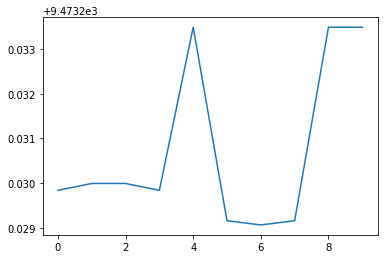

In [60]:
plt.plot(sse)

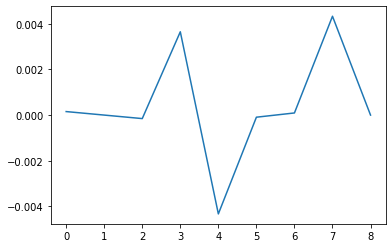

In [61]:
plt.plot([sse[i]-sse[i-1] for i in range(1,len(sse))])

In [87]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax)):
    kmeans = KMeans(n_clusters = k).fit(embeddings_df.values)
    labels = kmeans.labels_
    sil.append(silhouette_score(embeddings, labels, metric = 'euclidean'))

100%|██████████| 18/18 [04:59<00:00, 16.63s/it]


In [20]:
for k in tqdm(range(kmax+1, 2*kmax)):
    kmeans = KMeans(n_clusters = k).fit(embeddings)
    labels = kmeans.labels_
    sil.append(silhouette_score(embeddings, labels, metric = 'euclidean'))

100%|██████████| 9/9 [03:05<00:00, 20.59s/it]


In [21]:
for k in tqdm(range(2*kmax, 3*kmax)):
    kmeans = KMeans(n_clusters = k).fit(embeddings)
    labels = kmeans.labels_
    sil.append(silhouette_score(embeddings, labels, metric = 'euclidean'))

100%|██████████| 10/10 [04:37<00:00, 27.78s/it]


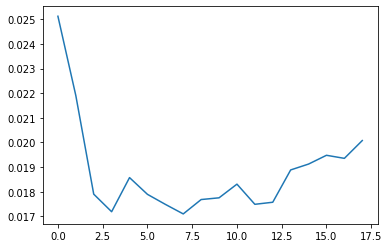

In [88]:
plt.plot(sil)

In [92]:
n_clusters = 12

In [93]:
kmeans = KMeans(n_clusters = n_clusters).fit(embeddings_df.values)
labels = kmeans.labels_
silhouette_score(embeddings_df.values, labels, metric = 'euclidean')


0.01858339544209467

In [131]:
# dists = [[np.linalg.norm(embeddings_df.iloc[i]-kmeans.cluster_centers_[j]) for i in range(len(embeddings_df))] for j in tqdm(list(range(n_clusters)))]

dists = [[spatial.distance.cosine(embeddings_df.iloc[i],kmeans.cluster_centers_[j]) for i in range(len(embeddings_df))] for j in tqdm(list(range(n_clusters)))]



100%|██████████| 12/12 [00:21<00:00,  1.82s/it]


In [132]:
dists_df = pd.DataFrame(dists, columns=embeddings_df.index).T

In [162]:
dists_df[11].sort_values().iloc[:20]

But that's not the point right now                  0.304092
But how would I rather spend the day                0.322648
But I'm more important to me                        0.323245
But it's more than that                             0.333360
But I don’t feel like doing anything...             0.335002
But it makes sense                                  0.350657
But I have to decide when enough                    0.360649
But what if staying hurts me                        0.360667
But I think not doing that might be worse for me    0.360990
But it's not for now                                0.361966
But that means nothing                              0.362220
But then I have to pay for ages 45-60               0.362945
But what about hurting me                           0.364702
But maybe sometimes.                                0.365919
But I have to push back                             0.367024
But it's up to me in my opinion                     0.368060
But that's nonsense     

In [107]:
# 0 - short expression
# 1 - questions
# 2 - values - it's good or bad 
# 3 - to do
# 4 - random thoughts?
# 5 - and do
# 6 - maybe
# 7 - maybe I / I want
# 8 - numbers
# 9 - money
# 10 - sex
# 11 - but

In [76]:
# ! pip install umap-learn

# Word Embeddings

In [3]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2022-06-21 01:42:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-06-21 01:42:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-21 01:42:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

In [47]:
from sklearn.metrics import silhouette_score

In [4]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [5]:

import numpy as np
embeddings_index = {}
with open('/tmp/glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [76]:
my_embeddings = {word: embeddings_index[word] for word in words if word in embeddings_index}

In [77]:
word_embeddings_df = pd.DataFrame(my_embeddings).T

In [78]:
word_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
translated,-0.483420,0.54375,-0.114550,0.587490,1.149900,0.733010,0.153090,-0.906680,0.18289,-0.240530,...,-0.103140,-0.068432,-0.124670,0.026833,-0.083475,-0.361080,-0.032084,-0.719910,-0.527130,0.323690
text,-0.497050,0.71642,0.401190,-0.057610,0.836140,0.825600,0.089630,-0.534920,0.34335,-0.270790,...,0.040066,0.608030,-0.027058,0.152730,-0.168870,-0.476640,-0.617750,-0.987350,0.237760,0.399520
:,-0.545580,1.09650,1.510600,-0.472700,-0.155470,0.217480,-0.361250,0.127270,-0.51148,-0.355280,...,0.016801,0.381540,0.394060,0.380440,-0.589430,-0.021365,0.173640,-0.903740,0.481360,0.030378
hey,0.377660,0.42608,1.158000,-0.660770,-0.562810,0.409020,0.024335,0.678350,0.20989,-0.585930,...,0.380030,0.129340,-0.017723,0.262210,-0.004755,-0.553120,-0.126100,-0.109850,-0.354420,0.380780
what,-0.151800,0.38409,0.893400,-0.424210,-0.921610,0.037988,-0.320260,0.003412,0.22101,-0.220450,...,0.274270,-0.218980,-0.267140,0.002256,-0.501780,-0.327750,-0.456700,-0.271230,0.221570,0.921120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fatter,-0.097295,0.61302,0.313910,-0.995940,0.002187,-0.661460,-1.151400,-0.705540,0.41621,-0.124950,...,0.895530,-0.075962,0.312830,-0.832450,0.032565,-0.669580,0.575760,0.662020,0.064074,0.334360
workouts,0.132590,-0.18258,-0.661800,-0.649600,-1.312300,0.401320,0.873480,0.884060,-1.32970,0.093087,...,-0.413940,0.166920,0.096516,0.519290,-0.005935,-0.309480,0.043702,-0.057437,1.047700,0.787170
clockwork,0.109430,-0.56458,-0.057436,-0.095496,0.454380,-0.001946,0.157890,0.167770,-0.53731,-0.284030,...,-0.014225,0.030894,-0.639740,0.110620,0.076050,-0.581340,-0.088268,-0.095719,-0.621890,0.158870
perseverance,0.224170,0.13555,0.230120,0.386420,-0.353250,0.160110,-0.781510,0.104160,-0.95742,-0.008918,...,-0.653140,-0.382630,-0.121460,0.976760,-0.026994,-0.400050,0.227110,-0.710070,0.128990,0.961650


In [49]:
sil = []
kmax = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax)):
    kmeans = KMeans(n_clusters = k).fit(word_embeddings_df.values)
    labels = kmeans.labels_
    sil.append(silhouette_score(word_embeddings_df.values, labels, metric = 'euclidean'))

100%|██████████| 18/18 [00:50<00:00,  2.78s/it]


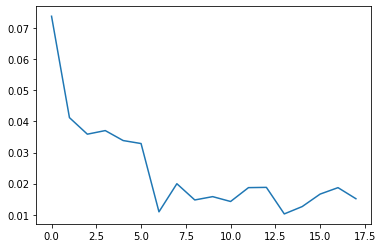

In [52]:
plt.plot(sil)

In [79]:
n_clusters = 10
kmeans = KMeans(n_clusters = n_clusters).fit(word_embeddings_df.values)
labels = kmeans.labels_
silhouette_score(word_embeddings_df.values, labels, metric = 'euclidean')


0.020211367

In [80]:
# dists = [[np.linalg.norm(embeddings_df.iloc[i]-kmeans.cluster_centers_[j]) for i in range(len(embeddings_df))] for j in tqdm(list(range(n_clusters)))]

dists = [[spatial.distance.cosine(word_embeddings_df.iloc[i],kmeans.cluster_centers_[j]) for i in range(len(word_embeddings_df))] for j in tqdm(list(range(n_clusters)))]



100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


In [81]:
dists_df = pd.DataFrame(dists, columns=word_embeddings_df.index).T

In [97]:
# 0 - nonesense
# 1 - stop words
# 0 - money 
# 3 - temporal
# 4 - spacial
# 5 - ?
# 6 - number
# 7 - math
# 8 - emotion
# 9 - rational

# 0 - money
# 1 - probable
# 2 - relationships
# 3 - numbers / nonsense
# 4 - stop words
# 5 - rational
# 6 - numbers
# 7 - daily nouns
# 8 - philosophy - long words
# 9 - temporal

In [99]:
dists_df[9].sort_values().iloc[:20]

one        0.118486
last       0.118993
the        0.120544
came       0.121020
only       0.122320
time       0.129756
.          0.138114
well       0.139797
while      0.141275
after      0.141343
another    0.142269
over       0.142639
but        0.142931
same       0.143375
before     0.145285
days       0.146549
first      0.146562
two        0.146680
next       0.146969
when       0.148549
Name: 9, dtype: float64

# Dimentionality Reduction

In [95]:
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [84]:
reducer = umap.UMAP()

In [80]:
scaled_embeddinbgs = StandardScaler().fit_transform(embeddings)

In [85]:
umap_embedding = reducer.fit_transform(scaled_embeddinbgs)

Text(0.5, 1.0, 'UMAP projection of the Penguin dataset')

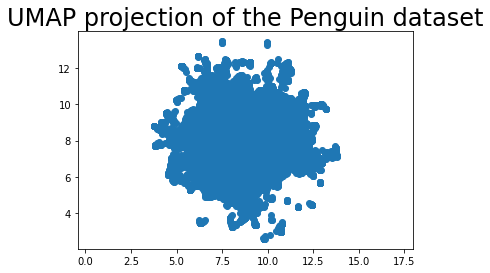

In [86]:
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1])
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24)

In [89]:
pca = PCA(n_components=2)

In [90]:
pca.fit(embeddings)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [91]:
pca.explained_variance_ratio_

array([0.03307248, 0.02561601])

In [92]:
pca_embeddings = pca.fit_transform(embeddings, None)

Text(0.5, 1.0, 'PCA projection')

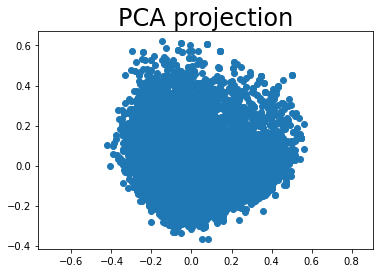

In [94]:
plt.scatter(
    pca_embeddings[:, 0],
    pca_embeddings[:, 1])
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection', fontsize=24)

In [97]:
tsne_embedded = TSNE(n_components=2,init='random').fit_transform(embeddings)

Text(0.5, 1.0, 'TSNE projection')

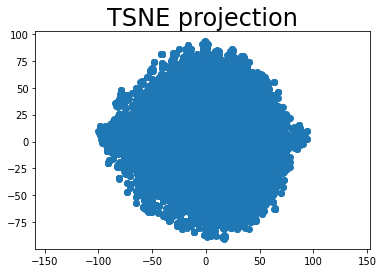

In [99]:
plt.scatter(
    tsne_embedded[:, 0],
    tsne_embedded[:, 1])
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection', fontsize=24)

# Sentiment Analysis

In [12]:
# ! pip install transformers==3.1
# ! pip3 install --upgrade tensorflow-gpu

In [6]:
from transformers import pipeline
import time

/usr/local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
sentiment_pipeline = pipeline("sentiment-analysis")

All model checkpoint weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [77]:
len(embeddings_df)

10312

In [15]:
sub_df = embeddings_df.index[2800-1:2800+100]

In [16]:
min(sub_df, key=len)

'Now'

In [17]:
data = list(sub_df)
sentiments = sentiment_pipeline(data)


In [27]:
embeddings_sentiments = []

In [28]:
sentiment_df = pd.DataFrame([], columns=['label','score'])

In [ ]:
for i in tqdm(range(len(embeddings_sentiments),len(embeddings_df),100)):
    data = list(embeddings_df.iloc[i:i+100].index)
    embeddings_sentiments = sentiment_pipeline(data)
    df = pd.DataFrame(embeddings_sentiments)
    sentiment_df = pd.concat([sentiment_df,df])
    sentiment_df.to_csv('data/thoughts/sentiment.csv')


100%|██████████| 104/104 [08:57<00:00,  5.17s/it]


In [39]:
# sentiment_df = sentiment_df.iloc[-len(embeddings_df):]

In [43]:
sentiment_df.to_csv('data/thoughts/sentiment.csv')

In [44]:
sentiment_df = pd.read_csv('data/thoughts/sentiment.csv', index_col=0)